<a href="https://colab.research.google.com/github/qagustina/mentoria-churnprediction/blob/master/Grupo2_Mentor%C3%ADaChurn_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DiploDatos 2022 - Mentoría "Churn Prediction: ¿Cómo retengo a mis clientes? Machine Learning aplicado a un caso de negocio"

---
**Trabajo Práctico Nº2 - Análisis Exploratorio y
Curación de datos**

**Integrantes Grupo 2**

*   Natalia Grasselli
*   Rodrigo Pizarro
*   Agustina Quirós
*   Natalia Tassin

In [ ]:
import pandas as pd
import seaborn as sns
sns.set_context('talk')
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno

In [ ]:
!pip install pandasql
from pandasql import sqldf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


En esta entrega vamos a trabajar con el dataset que creamos al final del entregable anterior.

In [ ]:
#Importamos el df
df_raw= pd.read_csv(
    'https://media.githubusercontent.com/media/qagustina/mentoria-churnprediction/master/df_churn_cleaned.csv')
df_raw.head(10)

,userId,page,song,artist,level,sessionId,ts,date,registration,churn_user
0,293.0,NextSong,Grand Designs,Martin Orford,free,292,1538352011,2018-10-01 0:00:11,1.532064e+12,1
1,98.0,NextSong,Bulls,John Brown's Body,free,97,1538352025,2018-10-01 0:00:25,1.538070e+12,0
2,179.0,NextSong,Because I Got High,Afroman,paid,178,1538352118,2018-10-01 0:01:58,1.535953e+12,0
3,179.0,Logout,NaN,NaN,paid,178,1538352119,2018-10-01 0:01:59,1.535953e+12,0
4,246.0,NextSong,Smile (Radio Edit),Lily Allen,paid,245,1538352124,2018-10-01 0:02:04,1.535931e+12,1
5,163.0,NextSong,Airplane Food,Carter USM,paid,162,1538352125,2018-10-01 0:02:05,1.533176e+12,0
6,NaN,Home,NaN,NaN,paid,178,1538352148,2018-10-01 0:02:28,NaN,0
7,NaN,Home,NaN,NaN,paid,178,1538352151,2018-10-01 0:02:31,NaN,0
8,NaN,Home,NaN,NaN,paid,178,1538352168,2018-10-01 0:02:48,NaN,0
9,NaN,Login,NaN,NaN,paid,178,1538352169,2018-10-01 0:02:49,NaN,0


In [ ]:
#trabajamos sobre una copia
df_churn = df_raw.copy()

# 1. Valores nulos, outliers o erróneos



## 1.a - Valores Nulos

En esta primera seccion vamos a analizar los valores nulos existentes y su impacto en el análisis del problema.



#### i. Proporción de valores nulos

> ¿Qué porcentaje representan los registros nulos de cada variable con respecto al total?




In [ ]:
df_churn.shape

(543705, 10)

In [ ]:
#Registros no nulos por columna
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 543705 entries, 0 to 543704
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   userId        528005 non-null  float64
 1   page          543705 non-null  object 
 2   song          432877 non-null  object 
 3   artist        432877 non-null  object 
 4   level         543705 non-null  object 
 5   sessionId     543705 non-null  int64  
 6   ts            543705 non-null  int64  
 7   date          543705 non-null  object 
 8   registration  528005 non-null  float64
 9   churn_user    543705 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 41.5+ MB


In [ ]:
#Registros nulos por columna
df_churn.isnull().sum()

userId           15700
page                 0
song            110828
artist          110828
level                0
sessionId            0
ts                   0
date                 0
registration     15700
churn_user           0
dtype: int64

Observamos que nuestro dataframe tiene 543705 registros. Las unicas columnas con valores nulos son `'userId'`,`'song'`,`'artist'` y `'registration'`.

La proporción de valores nulos sobre el total de valores de la variable para cada una de estas columnas es:



In [ ]:
#Contamos las proporciones de los valores nulos sobre el total de valores
nan_counts = round(df_churn.isnull().sum() / len(df_churn), 3)
nan_counts

userId          0.029
page            0.000
song            0.204
artist          0.204
level           0.000
sessionId       0.000
ts              0.000
date            0.000
registration    0.029
churn_user      0.000
dtype: float64

Así, notamos que las columnas que mayor cantidad de valores nulos poseen son song y artist, donde un 20% de sus valores son nulos. En el caso de userId y registration solo un 2% de sus valores son nulos.

El siguiente gráfico nos muestra en rojo los valores no nulos del df. Nos permite comparar las proporciones de valores nulos y no nulos entre columnas.

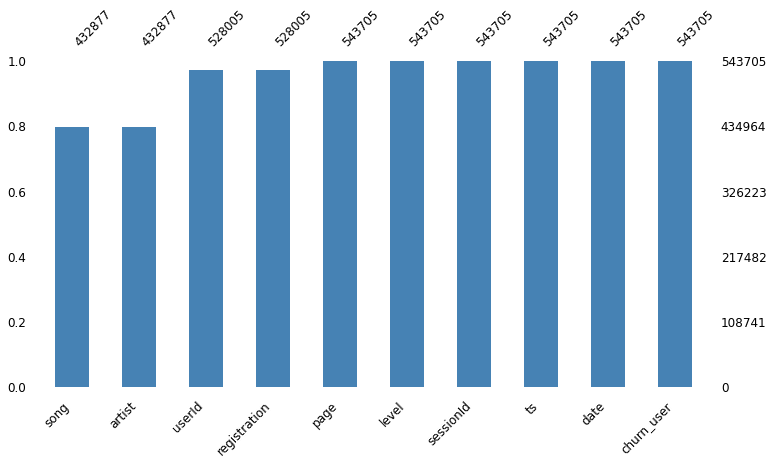

In [ ]:
#Grafico de barras
msno.bar(df_churn,figsize=(12, 6), sort="ascending",fontsize=12, color='steelblue') 

#### ii. Tratamiento de valores Nulos


> En base a esas cantidades, decida si es posible eliminar los registros,imputarlos de alguna manera o predecirlos.




A la hora de determinar como vamos a tratar los valores nulos en nuestro analisis, nos parece importante resaltar que, tal y como se mencionó en el entregable anterior, estos valores nulos tienen sentido dentro de la lógica de los datos, ya que para todas las acciones en las que el usuario todavía no está loggeado, el userId y registraton son nulos. 

Puesto que nuestro objetivo es predecir que usuarios van a hacer churn y que los valores de las filas donde `'userId'` es nulo no pueden vincularse con ningun usuario, estos no agregan ningun valor para nuestro analisis. De esta manera, se opta por eliminar los casos (filas) completas. 

In [ ]:
#Guardamos una copia
df_clean = df_churn.copy()

#Borramos las filas completas donde userId es nulo
df_clean.dropna(subset=['userId'],how='any',inplace=True)
df_clean['userId'].isnull().sum()

0

In [ ]:
df_clean.shape

(528005, 10)

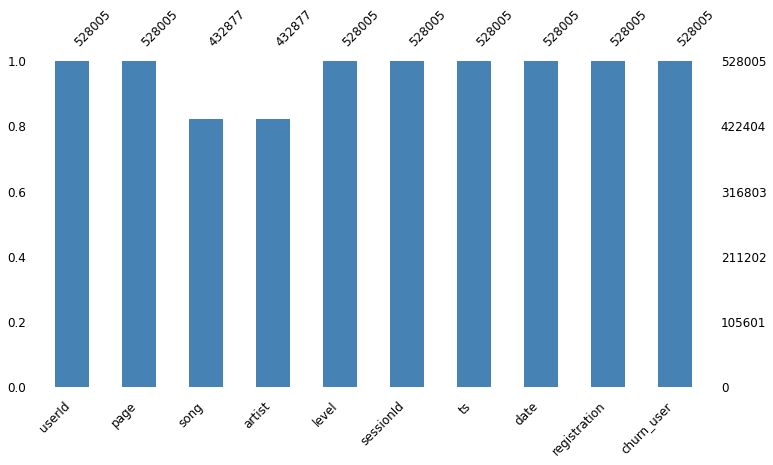

In [ ]:
#Vemos ahora como quedan las proporciones
msno.bar(df_clean,figsize=(12, 6), fontsize=12, color='steelblue')

Nuestro dataframe ahora tiene 528005 registros y ni userId ni registration poseen valores nulos.

Por otro lado, los campos `'artist'` y `'song'` son nulos para todas las acciones que no tengan que ver con canciones, como por ejemplo interactuar con *Home* o hacer login/logout. 

Así, decimos que estos no son valores perdidos que puedan imputarse por una constante, un valor estadístico o predecirse en base a otros valores; sino que se trata de datos inexistentes. Tampoco deberíamos eliminar las filas, como hicimos en el caso anterior, ya que los demás valores de las filas donde `'song'` y `'artist'` son nulos si resultan relevantes para nuestro analisis. 

De esta manera, lo que se decidió es mantener los valores nulos para estas variables tal y como están y utilizar las columnas para calcular otras variables que podrían ser interesantes para nuestro analisis (punto 2). Una vez calculadas estas nuevas columnas, las variables `'song'` y `'artist'` ya no serán necesarias para proceder con el modelo. Así, se descartará la columna completa y se obtendrá un df sin valores nulos. 

#### iii. Registros Duplicados 

> Verificar si existen registros duplicados que pudieran representar luego
un problema al modelo de clasificación. ¿Qué acción tomaría sobre
ellos?



In [ ]:
#Cantidad de registros que son duplicados
df_clean.duplicated().sum()

39

In [ ]:
#Registros duplicados
df_clean[df_clean.duplicated(keep=False)]

,userId,page,song,artist,level,sessionId,ts,date,registration,churn_user
15108,288.0,Roll Advert,NaN,NaN,free,546,1538574346,2018-10-03 13:45:46,1.522793e+12,1
15109,288.0,Roll Advert,NaN,NaN,free,546,1538574346,2018-10-03 13:45:46,1.522793e+12,1
20533,70.0,About,NaN,NaN,paid,449,1538646363,2018-10-04 9:46:03,1.529643e+12,0
20534,70.0,About,NaN,NaN,paid,449,1538646363,2018-10-04 9:46:03,1.529643e+12,0
26932,66.0,Home,NaN,NaN,paid,885,1538738189,2018-10-05 11:16:29,1.532634e+12,0
...,...,...,...,...,...,...,...,...,...,...
508805,300001.0,Home,NaN,NaN,paid,558,1541411468,2018-11-05 9:51:08,1.526739e+12,0
508904,300035.0,Home,NaN,NaN,paid,602,1541415636,2018-11-05 11:00:36,1.538178e+12,0
508905,300035.0,Home,NaN,NaN,paid,602,1541415636,2018-11-05 11:00:36,1.538178e+12,0
541586,300040.0,Home,NaN,NaN,free,905,1543503841,2018-11-29 15:04:01,1.537338e+12,0


Observamos que hay 39 filas que están repetidas. Es decir, que refieren a una misma interacción de la página. Podríamos suponer que estos registros duplicados no agregan información, ya que no significa que una acción se haya llevado a cabo dos veces; sino que simplemente se las registró de manera duplicada. 

En función de ello, optamos por eliminar las filas que están duplicadas y quedarnos solo con una de ellas. 

In [ ]:
#eliminamos valores duplicados
df_clean.drop_duplicates(inplace=True)

In [ ]:
#Ya no hay registros duplicados
df_clean.duplicated().sum()

0

## 1.b - Outliers en variables Numéricas
Analizar si existen valores outliers en las variables numéricas, indagar si
realmente son valores atípicos o son casos excepcionales que deben tenerse
en cuenta. ¿Qué porcentaje representan? ¿Los eliminamos o mantenemos
cierto porcentaje de ellos (percentiles)?


En un principio, tal y como se encuentra planteado el dataframe actualmente, no habría valores extremos de variables numéricas; ya que en general estas representan relaciones de pertenencia o clasificación (userId, sessionId,churn_user) o de tiempo (ts, registration). Por lo tanto, en un principio no abría valores extremos para descartar. 

In [ ]:
df_clean.describe()

,userId,sessionId,ts,registration,churn_user
count,527966.000000,527966.000000,5.279660e+05,5.279660e+05,527966.000000
mean,60264.917964,2043.035783,1.540967e+09,1.535523e+12,0.196285
std,109898.441880,1433.983421,1.481234e+06,3.078677e+09,0.397187
min,2.000000,1.000000,1.538352e+09,1.509854e+12,0.000000
25%,96.000000,632.000000,1.539723e+09,1.534368e+12,0.000000
50%,201.000000,1973.000000,1.541007e+09,1.536556e+12,0.000000
75%,100008.000000,3310.000000,1.542178e+09,1.537612e+12,0.000000
max,300051.000000,4808.000000,1.543622e+09,1.543074e+12,1.000000


## 1.c - Valores erroneos

¿Existen valores erróneos? Analizar cómo tratarlos, si dejarlos como están
porque tienen cierto significado, eliminar las filas donde están esos valores
erróneos o imputarlos de alguna manera.


Algunos posibles valores erroneos podrían ser: 

> Que un usuario que ve un anuncio esté clasificado como pago:



In [ ]:
print('cantidad de usuarios pagos que ven anuncios:', 
        df_clean[(df_clean.page == 'Roll Advert') & 
            (df_clean.level == 'Paid')].size)

cantidad de usuarios pagos que ven anuncios: 0


Observamos que no existen usuario no pagos que vean anuncios. Por lo que podríamos en un principio asumir que los usuarios paid se encuentran computados adecuadamente.

> UserIds o SessioIds negativos o nulos




In [ ]:
#cantidad de userIds no positivos
print('cantidad de userIds no positivos:', 
        df_clean[df_clean.userId <=0].size)

#cantidad de sessionIds no positivos
print('cantidad de sessionIds no positivos:', 
        df_clean[df_clean.sessionId <=0].size)

cantidad de userIds no positivos: 0
cantidad de sessionIds no positivos: 0


> Registration dates posteriores a la fecha de la acción:


In [ ]:
print('registration dates mal computadas:', 
        df_clean[df_clean.registration <= df_clean.ts].size)

registration dates mal computadas: 0


> SessionIds repetidas



In [ ]:
df_clean.sessionId.nunique()

4470

In [ ]:
df_clean[['userId','sessionId']].nunique()

userId        448
sessionId    4470
dtype: int64

Notamos que, hasta ahora, no hemos encontrado valores erroneos significativos en el df. 

Un caso particular donde podría haber valores erroneos, podría ser en el nombre de algún artista o nombre de canción, pero para nuestro caso, no nos interesa el nombre en sí de la canción o del artista, por lo tanto tampoco nos interesaría imputarlos o eliminarlos.

## 1.d- Cantidad de registros 

Concluir luego de ésta “limpieza” cuántos registros hemos mantenido/eliminado. Con el fin de no quedarnos con muy pocos registros para avanzar más adelante con algún modelo de clasificación.



In [ ]:
#N° de elementos del df original
df_churn.shape

(543705, 10)

In [ ]:
#N° de elementos del df original
df_clean.shape

(527966, 10)

In [ ]:
#N° de filas eliminadas
droped_rows = df_churn.shape[0] - df_clean.shape[0]
print('N° filas eliminadas:', droped_rows)
print('Porcentaje de filas eliminadas:', round(100*droped_rows/df_churn.shape[0],2),'%')

N° filas eliminadas: 15739
Porcentaje de filas eliminadas: 2.89 %


## 1.e - Balance de clases

Analizar cómo quedaron las clases chur y no churn luego de la limpieza del dataset, ¿se mantiene la proporción de cada clase?

In [ ]:
#Cantidad de usuarios churn vs no churn df original
df_churn.groupby('userId', as_index=False).agg({'churn_user': 'first'})['churn_user'].value_counts()

0    349
1     99
Name: churn_user, dtype: int64

In [ ]:
#Cantidad de usuarios churn vs no churn después de la limpieza
df_clean.groupby('userId', as_index=False).agg({'churn_user': 'first'})['churn_user'].value_counts()

0    349
1     99
Name: churn_user, dtype: int64

Notamos que no ocurrieron cambios en el balance de clases a partir de la limpieza.

#2- Transformación de datos existentes

## 2.a - Nuevas Columnas 



> Vamos a agregar nuevas columnas con información que consideramos puede ser relevante. Estas se calcularán a nivel usuario.

In [ ]:
#Para trabajar vamos a hacer una copia del df
df_new_cols = df_clean.copy()

#### Número de veces que el usuario realizó la acción de escuchar una canción:

In [ ]:
#Calculamos los valores de la columna
agregate_song_count = df_new_cols.groupby('userId', as_index=False).agg({'song': ['count']})
agregate_song_count.columns = agregate_song_count.columns.get_level_values(0) + '_' +  agregate_song_count.columns.get_level_values(1)
agregate_song_count[:3]

,userId_,song_count
0,2.0,779
1,3.0,24
2,4.0,421


In [ ]:
#Agregamos mediante un left join por usuario
if 'songsCountByUser' not in df_new_cols.columns:
  df_new_cols = df_new_cols.join(agregate_song_count.set_index('userId_'),on='userId', how='left')
  df_new_cols.rename(columns = {'song_count':'songsCountByUser'}, inplace = True)

#### Cantidad de canciones únicas escuchadas por el usuario:

In [ ]:
#Calculamos los valores de la columna
agregate_unique_song_count = df_new_cols.groupby('userId', as_index=False).agg({'song': ['nunique']})
agregate_unique_song_count.columns = agregate_unique_song_count.columns.get_level_values(0) + '_' +  agregate_unique_song_count.columns.get_level_values(1)
agregate_unique_song_count[:3]

,userId_,song_nunique
0,2.0,741
1,3.0,24
2,4.0,403


In [ ]:
#Agregamos mediante un left join por usuario
if 'uniqueSongsListenedByUser' not in df_new_cols.columns:
  df_new_cols = df_new_cols.join(agregate_unique_song_count.set_index('userId_'),on='userId', how='left')
  df_new_cols.rename(columns = {'song_nunique':'uniqueSongsListenedByUser'}, inplace = True)

#### Cantidad de artistas únicos escuchados por el usuario: 

In [ ]:
#Calculamos los valores de la columna
agregate_artist_count = df_new_cols.groupby('userId', as_index=False).agg({'artist': ['nunique']})
agregate_artist_count.columns = agregate_artist_count.columns.get_level_values(0) + '_' +  agregate_artist_count.columns.get_level_values(1)
agregate_artist_count[:3]

,userId_,artist_nunique
0,2.0,632
1,3.0,24
2,4.0,364


In [ ]:
#Agregamos mediante un left join por usuario
if 'artistsListenedByUser' not in df_new_cols.columns:
  df_new_cols = df_new_cols.join(agregate_artist_count.set_index('userId_'),on='userId', how='left')
  df_new_cols.rename(columns = {'artist_nunique':'artistsListenedByUser'}, inplace = True)

#### Media y desviación estandar del numero de canciones escuchadas por artista

In [ ]:
#cantidad de canciones por artista que escucha cada usuario
user_artist_song_count = df_new_cols.groupby(['userId','artist'], as_index=False).agg({'song': ['count']})
user_artist_song_count.columns = user_artist_song_count.columns.get_level_values(0) + '_' +  user_artist_song_count.columns.get_level_values(1)
user_artist_song_count[:3]

,userId_,artist_,song_count
0,2.0,24-7 Spyz,1
1,2.0,3 Doors Down,1
2,2.0,3OH!3,1


In [ ]:
#media y desv estandar de canciones por artista que escucha cada usuario
user_artist_mean_std = user_artist_song_count.groupby('userId_',as_index=False).agg({'song_count': ['mean','std']})
user_artist_mean_std.columns = user_artist_mean_std.columns.get_level_values(0) + '_' +  user_artist_mean_std.columns.get_level_values(1)
user_artist_mean_std[:3]

,userId__,song_count_mean,song_count_std
0,2.0,1.232595,0.784970
1,3.0,1.000000,0.000000
2,4.0,1.156593,0.550667


In [ ]:
#Agregamos mediante un left join por usuario
if 'MeanSongCountByArtist' not in df_new_cols.columns:
  if 'StdSongCountByArtist' not in df_new_cols.columns:
    df_new_cols = df_new_cols.join(user_artist_mean_std.set_index('userId__'),on='userId', how='left')
    df_new_cols.rename(columns = {'song_count_mean':'MeanSongCountByArtist'}, inplace = True)
    df_new_cols.rename(columns = {'song_count_std':'StdSongCountByArtist'}, inplace = True)

df_new_cols['StdSongCountByArtist'] = df_new_cols['StdSongCountByArtist'].fillna(0) 

#### Cantidad de canciones escuchadas por sesión:

In [ ]:
#Calculamos los valores de la columna

user_session_song_count = df_new_cols.groupby(['userId','sessionId'], as_index=False).agg({'song': ['count']})
user_session_song_count.columns = user_session_song_count.columns.get_level_values(0) + '_' +  user_session_song_count.columns.get_level_values(1)
user_session_song_count[:3]

,userId_,sessionId_,song_count
0,2.0,1,11
1,2.0,1074,59
2,2.0,1576,346


In [ ]:
#Agregamos mediante un left join por sessiónId y userId
if 'SongCountBySession' not in df_new_cols.columns:
  df_new_cols = pd.merge(df_new_cols, user_session_song_count,  how='left', left_on=['userId','sessionId'], right_on = ['userId_','sessionId_'])
  df_new_cols.rename(columns = {'song_count':'SongCountBySession'}, inplace = True)
  df_new_cols.drop(labels=['sessionId_','userId_'], axis=1)

#### Duración promedio de las sesiones

In [ ]:
#Calculamos la duración promedio de la sesión:

session_lenght_df = sqldf("""
  SELECT df_new_cols.*, sessionLengthInSeconds
  FROM df_new_cols
    INNER JOIN (
      SELECT ma-m sessionLengthInSeconds, sessionId
      FROM(
        SELECT min(ts) m, max(ts) ma, sessionId
        FROM df_new_cols 
        GROUP BY sessionId
        ) as mm
      ) as t 
    on t.sessionId = df_new_cols.sessionId
  """, globals()) 

session_mean_df = session_lenght_df.groupby('userId', as_index=False).agg({'sessionLengthInSeconds': ['mean']})
session_mean_df.columns = session_mean_df.columns.get_level_values(0) + '_' +  session_mean_df.columns.get_level_values(1)

In [ ]:
#Agregamos la columna
if 'meanSessionLengthInSeconds' not in df_new_cols.columns:
  df_new_cols = df_new_cols.join(session_mean_df.set_index('userId_'),on='userId', how='left')
  df_new_cols.rename(columns = {'sessionLengthInSeconds_mean':'meanSessionLengthInSeconds'}, inplace = True)

#### Número de sesiones por usuario

In [ ]:
#Calculamos la columna: num sesiones x usuario
sessions_by_user = df_new_cols.groupby('userId', as_index=False).agg({'sessionId': ['nunique']})
sessions_by_user.columns = sessions_by_user.columns.get_level_values(0) + '_' +  sessions_by_user.columns.get_level_values(1)
sessions_by_user[:3]

,userId_,sessionId_nunique
0,2.0,11
1,3.0,1
2,4.0,16


In [ ]:
#Agregamos mediante un join sobre userId
if 'countSessionsByUser' not in df_new_cols.columns:
  df_new_cols = df_new_cols.join(sessions_by_user.set_index('userId_'), on='userId', how='left')
  df_new_cols.rename(columns = {'sessionId_nunique':'countSessionsByUser'}, inplace = True)

#### Tasa de Rebote del usuario: cantidad de sesiones con un solo registro / cantidad de sesiones del usuario

In [ ]:
#Cuento las acciones por usuario por session
page_bounce_count = df_new_cols.groupby(['userId','sessionId'], as_index=False).agg({'page': ['count']})
page_bounce_count.columns = page_bounce_count.columns.get_level_values(0) + '_' +  page_bounce_count.columns.get_level_values(1)
page_bounce_count[:3]

,userId_,sessionId_,page_count
0,2.0,1,13
1,2.0,1074,75
2,2.0,1576,422


In [ ]:
#Cuento la cantidad de veces que un usuario hace solo una acción (cantidad de rebotes)
bounce_count = page_bounce_count[page_bounce_count.page_count == 1].groupby(['userId_'], as_index=False).agg({'page_count': ['count']})
bounce_count.columns = bounce_count.columns.get_level_values(0) + '_' +  bounce_count.columns.get_level_values(1)
bounce_count[:3] #en este df solo aparecen los usuarios que alguna vez rebotaron

,userId__,page_count_count
0,6.0,1
1,12.0,1
2,17.0,2


In [ ]:
#Agrego la cantidad de sesiones que inició el usuario 
#(calculada en item anterior)
bounce_count_session = bounce_count.join(sessions_by_user.set_index('userId_'), on='userId__', how='left')
bounce_count_session[:3] #en este df solo aparecen los usuarios que alguna vez rebotaron

,userId__,page_count_count,sessionId_nunique
0,6.0,1,19
1,12.0,1,24
2,17.0,2,27


In [ ]:
#Calculo  la tasa
bounce_count_session['BounceRate'] = round(bounce_count_session.page_count_count/bounce_count_session.sessionId_nunique,4)
bounce_count_session[:3] #en este df solo aparecen los usuarios que alguna vez rebotaron

,userId__,page_count_count,sessionId_nunique,BounceRate
0,6.0,1,19,0.0526
1,12.0,1,24,0.0417
2,17.0,2,27,0.0741


In [ ]:
#Agregamos la columna: Tasa de Rebote
if 'BounceRate' not in df_new_cols.columns:
  df_new_cols = df_new_cols.join(bounce_count_session['BounceRate'],on='userId', how='left')

#Va a haber NaNs para cada usuario que nunca haya rebotado
#Remplazo esos NaNs con 0s
df_new_cols['BounceRate'] = df_new_cols['BounceRate'].fillna(0) 

#### Numero de amigos agregados

In [ ]:
#Calculamos la columna: num de amigos x usuario
agregate_friend_count = df_new_cols[df_new_cols.page=='Add Friend'].groupby('userId', as_index=False).agg({'page': ['count']})
agregate_friend_count.columns = agregate_friend_count.columns.get_level_values(0) + '_' +  agregate_friend_count.columns.get_level_values(1)
agregate_friend_count[:3]

,userId_,page_count
0,2.0,14
1,4.0,7
2,5.0,1


In [ ]:
# Numero de friends (page = "Add Friend")
if 'FriendsCountByUser' not in df_new_cols.columns:
  df_new_cols = df_new_cols.join(agregate_friend_count.set_index('userId_'),on='userId', how='left')
  df_new_cols.rename(columns = {'page_count':'FriendsCountByUser'}, inplace = True)

df_new_cols['FriendsCountByUser'] = df_new_cols['FriendsCountByUser'].fillna(0) 

#### Cantidad de MeGustas

In [ ]:
#Calculamos la columna: num de Thumbs Up x usuario
agregate_likes_count = df_new_cols[df_new_cols.page=='Thumbs Up'].groupby('userId', as_index=False).agg({'page': ['count']})
agregate_likes_count.columns = agregate_likes_count.columns.get_level_values(0) + '_' +  agregate_likes_count.columns.get_level_values(1)
agregate_likes_count[:3]

,userId_,page_count
0,2.0,35
1,4.0,27
2,5.0,12


In [ ]:
# Numero de MeGustas (page = "Thumbs Up")
if 'LikesCountByUser' not in df_new_cols.columns:
  df_new_cols = df_new_cols.join(agregate_likes_count.set_index('userId_'),on='userId', how='left')
  df_new_cols.rename(columns = {'page_count':'LikesCountByUser'}, inplace = True)

df_new_cols['LikesCountByUser'] = df_new_cols['LikesCountByUser'].fillna(0)

#### Cantidad de Anuncios



In [ ]:
#Calculamos la columna: num de Roll Advert x usuario
agregate_adds_count = df_new_cols[df_new_cols.page=='Roll Advert'].groupby('userId', as_index=False).agg({'page': ['count']})
agregate_adds_count.columns = agregate_adds_count.columns.get_level_values(0) + '_' +  agregate_adds_count.columns.get_level_values(1)
agregate_adds_count[:3]

,userId_,page_count
0,3.0,1
1,4.0,36
2,5.0,19


In [ ]:
# Numero de Anuncios (page = "Roll Advert")
if 'AddsSeen' not in df_new_cols.columns:
  df_new_cols = df_new_cols.join(agregate_adds_count.set_index('userId_'),on='userId', how='left')
  df_new_cols.rename(columns = {'page_count':'AddsSeen'}, inplace = True)

df_new_cols['AddsSeen'] = df_new_cols['AddsSeen'].fillna(0) 

#### Cantidad de Errores



In [ ]:
#Calculamos la columna: num de Error x usuario
agregate_error_count = df_new_cols[df_new_cols.page=='Error'].groupby('userId', as_index=False).agg({'page': ['count']})
agregate_error_count.columns = agregate_error_count.columns.get_level_values(0) + '_' +  agregate_error_count.columns.get_level_values(1)
agregate_error_count[:3]

,userId_,page_count
0,2.0,1
1,4.0,2
2,6.0,2


In [ ]:
# Numero de Errores (page = "Error")
if 'Error' not in df_new_cols.columns:
  df_new_cols = df_new_cols.join(agregate_error_count.set_index('userId_'),on='userId', how='left')
  df_new_cols.rename(columns = {'page_count':'Error'}, inplace = True)

df_new_cols['Error'] = df_new_cols['Error'].fillna(0) 

#### Cantidad de Interacciones del usuario

In [ ]:
#Calculamos la columna: interacciones por usuario
agregate_count = df_new_cols.groupby('userId', as_index=False).agg({'page': ['count']})
agregate_count.columns = agregate_count.columns.get_level_values(0) + '_' +  agregate_count.columns.get_level_values(1)
agregate_count[:3]

,userId_,page_count
0,2.0,941
1,3.0,25
2,4.0,542


In [ ]:
#Numero de Interacciones
if 'NumInteracc' not in df_new_cols.columns:
  df_new_cols = df_new_cols.join(agregate_count.set_index('userId_'),on='userId', how='left')
  df_new_cols.rename(columns = {'page_count':'NumInteracc'}, inplace = True)

df_new_cols['NumInteracc'] = df_new_cols['NumInteracc'].fillna(0) 

#### Dataframe Resultante

In [ ]:
df_new_cols[:5]

,userId,page,song,artist,level,sessionId,ts,date,registration,churn_user,...,sessionId_,SongCountBySession,meanSessionLengthInSeconds,countSessionsByUser,BounceRate,FriendsCountByUser,LikesCountByUser,AddsSeen,Error,NumInteracc
0,293.0,NextSong,Grand Designs,Martin Orford,free,292,1538352011,2018-10-01 0:00:11,1.532064e+12,1,...,292,45,6.329876e+05,58,0.0000,84.0,227.0,51.0,4.0,5125
1,98.0,NextSong,Bulls,John Brown's Body,free,97,1538352025,2018-10-01 0:00:25,1.538070e+12,0,...,97,4,1.184140e+05,29,0.0444,39.0,131.0,7.0,7.0,3206
2,179.0,NextSong,Because I Got High,Afroman,paid,178,1538352118,2018-10-01 0:01:58,1.535953e+12,0,...,178,118,1.168993e+05,20,0.0000,45.0,94.0,4.0,0.0,2639
3,179.0,Logout,NaN,NaN,paid,178,1538352119,2018-10-01 0:01:59,1.535953e+12,0,...,178,118,1.168993e+05,20,0.0000,45.0,94.0,4.0,0.0,2639
4,246.0,NextSong,Smile (Radio Edit),Lily Allen,paid,245,1538352124,2018-10-01 0:02:04,1.535931e+12,1,...,245,142,1.186222e+06,23,0.0000,39.0,153.0,23.0,5.0,3566


## 2.b - Transformar variables categóricas a numéricas

Pasar las variables categóricas (strings) a numéricas. Analizar diferentes métodos para elegir el más adecuado (One hot encoding, categorías numéricas)

#### Revisamos el df

In [ ]:
#Miramos las columnas de df
df_new_cols.dtypes

userId                        float64
page                           object
song                           object
artist                         object
level                          object
sessionId                       int64
ts                              int64
date                           object
registration                  float64
churn_user                      int64
songsCountByUser                int64
uniqueSongsListenedByUser       int64
artistsListenedByUser           int64
MeanSongCountByArtist         float64
StdSongCountByArtist          float64
userId_                       float64
sessionId_                      int64
SongCountBySession              int64
meanSessionLengthInSeconds    float64
countSessionsByUser             int64
BounceRate                    float64
FriendsCountByUser            float64
LikesCountByUser              float64
AddsSeen                      float64
Error                         float64
NumInteracc                     int64
dtype: objec

In [ ]:
df_new_cols[:3]

,userId,page,song,artist,level,sessionId,ts,date,registration,churn_user,...,sessionId_,SongCountBySession,meanSessionLengthInSeconds,countSessionsByUser,BounceRate,FriendsCountByUser,LikesCountByUser,AddsSeen,Error,NumInteracc
0,293.0,NextSong,Grand Designs,Martin Orford,free,292,1538352011,2018-10-01 0:00:11,1.532064e+12,1,...,292,45,632987.613854,58,0.0000,84.0,227.0,51.0,4.0,5125
1,98.0,NextSong,Bulls,John Brown's Body,free,97,1538352025,2018-10-01 0:00:25,1.538070e+12,0,...,97,4,118413.986276,29,0.0444,39.0,131.0,7.0,7.0,3206
2,179.0,NextSong,Because I Got High,Afroman,paid,178,1538352118,2018-10-01 0:01:58,1.535953e+12,0,...,178,118,116899.250474,20,0.0000,45.0,94.0,4.0,0.0,2639


#### Separamos las columnas categóricas

Nuestro conjunto de datos cuenta con x columnas que contienen variables categóricas que deseamos transformar en variables numericas. Recordamos que las columnas `'song'` y `'artist'` ya no las vamos a usar porque no aportan información relevante. 

Así, las columnas categóricas a considerar son:

In [ ]:
categorical_cols = ['page', 'level'] # ,'date' 

Para realizar dicha transformación, vamos a aplicar el proceso **One-Hot Encoding**. Este proceso convierte las variables categoricas en variables binarias; creando una columna para cada valor distinto que exista en la característica que estamos codificando y, para cada registro, marcar con un 1 la columna a la que pertenezca dicho registro y dejar las demás con 0.

Sklearn trae una herramienta que nos permite aplicar este tipo de encoding, se llama OneHotEncoder. Esta clase solo puede aplicarse sobre columnas categoricas, por lo que vamos a separar nuestro df:

In [ ]:
#Separamos as variables categoricas del df para poder aplicar One-Hot Encoding

categorical_df = df_new_cols[categorical_cols]
categorical_df[:3]

,page,level
0,NextSong,free
1,NextSong,free
2,NextSong,paid


In [ ]:
# Check for nulls
categorical_df.isna().sum()

page     0
level    0
dtype: int64

#### Aplicamos One-Hot

Ahora, vamos a aplicar el metodo OneHotEncoding de sklearn sobre las variables categoricas

In [ ]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder()
enc.fit(categorical_df)

OneHotEncoder()

In [ ]:
#Nombres de las columnas categoricas
enc.feature_names_in_

array(['page', 'level'], dtype=object)

In [ ]:
#Unique categories found when fitting
enc.categories_

[array(['About', 'Add Friend', 'Add to Playlist', 'Cancel',
        'Cancellation Confirmation', 'Downgrade', 'Error', 'Help', 'Home',
        'Logout', 'NextSong', 'Roll Advert', 'Save Settings', 'Settings',
        'Submit Downgrade', 'Submit Upgrade', 'Thumbs Down', 'Thumbs Up',
        'Upgrade'], dtype=object), array(['free', 'paid'], dtype=object)]

In [ ]:
#transformamos los datos.
encoded_matrix = enc.transform(categorical_df)
encoded_matrix

<527966x21 sparse matrix of type '<class 'numpy.float64'>'
	with 1055932 stored elements in Compressed Sparse Row format>

El resultado es una matriz esparsa. A esta debemos agregarle nuevamente las variables numericas.

#### Agregamos variables numericas

In [ ]:
#df de variables numericas
numerical_cols = ['songsCountByUser','uniqueSongsListenedByUser', 
                  'artistsListenedByUser','MeanSongCountByArtist', 
                  'StdSongCountByArtist', 'SongCountBySession', 
                  'meanSessionLengthInSeconds', 'countSessionsByUser', 
                  'BounceRate', 'FriendsCountByUser', 'LikesCountByUser',
                  'AddsSeen','Error','NumInteracc']
numerical_df = df_new_cols[numerical_cols]
numerical_df[:3]

In [ ]:
from scipy import sparse

# Stack numerical columns onto the left of the sparse matrix
matrix = sparse.hstack((sparse.csr_matrix(numerical_df.values), encoded_matrix))
matrix

# Keep track of features
features = np.concatenate((numerical_df.columns.values, enc.get_feature_names_out()))

In [ ]:
matrix

<527966x35 sparse matrix of type '<class 'numpy.float64'>'
	with 7925315 stored elements in COOrdinate format>

##2.c - Normalizar / Escalar / Estandarizar

Transformar los features para que tengan distribuciones más cercanas a la normal (elegir qué método es más conveniente: escalar, normalizar, estandarizar).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


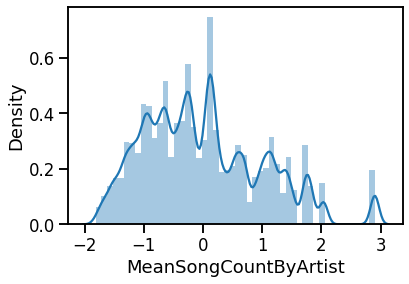

In [ ]:
from sklearn.preprocessing import StandardScaler, MaxAbsScaler

matrix_df = pd.DataFrame.sparse.from_spmatrix(matrix, index=None, columns=features)
dense_df = matrix_df.sparse.to_dense()

# Estandarización

scaler = StandardScaler()
scaled_matrix = scaler.fit_transform(dense_df)

# Normalización
#normalizer = MaxAbsScaler()
#normalized_matrix = normalizer.fit_transform(dense_df)

scaled_df = pd.DataFrame(scaled_matrix, index=None, columns=features)

sns.distplot(scaled_df["MeanSongCountByArtist"])

In [ ]:
scaled_df.isna().sum().sum() # Validación de que no haya NaNs antes de PCA

0

#### Volvemos a agregar las columnas userId y churn_user

In [ ]:
user_cols = ['userId','churn_user','sessionId','ts','registration']
user_df = df_new_cols[user_cols]
user_df[:3]

,userId,churn_user,sessionId,ts,registration
0,293.0,1,292,1538352011,1.532064e+12
1,98.0,0,97,1538352025,1.538070e+12
2,179.0,0,178,1538352118,1.535953e+12


In [ ]:
from scipy import sparse

# Stack numerical columns onto the left of the sparse matrix
full_matrix = sparse.hstack((sparse.csr_matrix(user_df.values), scaled_matrix))

# Keep track of features
features = np.concatenate((user_df.columns.values, numerical_df.columns.values, enc.get_feature_names_out()))

In [ ]:
sparce_full_df = pd.DataFrame.sparse.from_spmatrix(full_matrix, index=None, columns=features)
dense_full_df = sparce_full_df.sparse.to_dense()
dense_full_df[:3]

,userId,churn_user,sessionId,ts,registration,songsCountByUser,uniqueSongsListenedByUser,artistsListenedByUser,MeanSongCountByArtist,StdSongCountByArtist,...,page_Roll Advert,page_Save Settings,page_Settings,page_Submit Downgrade,page_Submit Upgrade,page_Thumbs Down,page_Thumbs Up,page_Upgrade,level_free,level_paid
0,293.0,1.0,292.0,1.538352e+09,1.532064e+12,1.103343,1.149317,1.177487,1.115855,1.021120,...,-0.122152,-0.033305,-0.075074,-0.014888,-0.023321,-0.096897,-0.217395,-0.042814,1.949918,-1.949918
1,98.0,0.0,97.0,1.538352e+09,1.538070e+12,0.214459,0.266357,0.372009,0.317601,0.306926,...,-0.122152,-0.033305,-0.075074,-0.014888,-0.023321,-0.096897,-0.217395,-0.042814,1.949918,-1.949918
2,179.0,0.0,178.0,1.538352e+09,1.535953e+12,-0.052378,-0.015710,0.060291,0.150003,0.253105,...,-0.122152,-0.033305,-0.075074,-0.014888,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842


##2.d - Método PCA

Analizar la posibilidad de incluir nuevas columnas con el método PCA (éste paso debe realizarse luego de escalar o estandarizar las variables, para que en las componentes PCA las variables sean “pesadas” de manera similar, y no tenga alto impacto la varianza de las columnas originales)

In [ ]:
from sklearn.decomposition import PCA
n = min(15, scaled_matrix.shape[0])
pca = PCA(n_components=n)
pca.fit(scaled_matrix)
proyected_features = pca.transform(scaled_matrix)
proyected_features.shape


(527966, 15)

In [ ]:
print("Principal components")
print(pca.components_)
print("Explained variance ratio")
print(pca.explained_variance_ratio_)

Principal components
[[ 3.19760187e-01  3.20252151e-01  3.18862986e-01  3.18458313e-01
   3.19184315e-01  6.85075928e-02 -2.50240838e-02  2.91056527e-01
   2.64449543e-02  3.10015661e-01  2.98794360e-01  7.98636924e-02
   2.80717780e-01  3.20179614e-01 -1.59791506e-04  9.35937811e-05
   1.01418743e-03 -4.44670057e-03 -4.44670057e-03  2.78280944e-03
   6.47476969e-04 -4.91033274e-04 -5.80363455e-03 -4.16389572e-03
   1.28749926e-02 -2.91904074e-02 -1.65488686e-03 -1.16660046e-03
  -1.60275795e-03 -4.85278471e-03 -2.50514952e-03  3.67032478e-03
  -9.57074190e-03 -1.12134814e-01  1.12134814e-01]
 [ 3.46978974e-02  2.47311266e-02  9.19293207e-03  7.97139071e-03
   1.62548554e-02 -3.07781753e-01  3.41948606e-02  1.44204071e-01
  -2.44756021e-02  5.48123962e-02  3.39033956e-02  3.79090035e-01
   5.29631152e-02  4.21178467e-02  1.10408720e-02  3.54589457e-02
   3.26301081e-02  5.20650609e-03  5.20650599e-03 -1.74876688e-02
   8.74767033e-03  1.90119511e-02  7.84909822e-02  4.99615501e-02
  -2

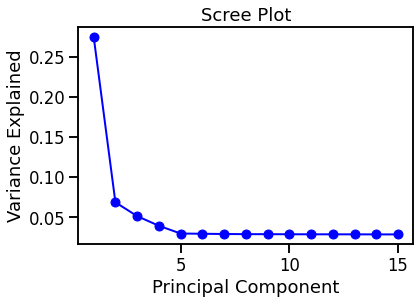

In [ ]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Podemos ver que hay al menos 3/4 componentes principales que se podrían agregar valore a la matriz 

In [ ]:
pca_df = pd.DataFrame(data = proyected_features, columns = ['PC 1', 'PC 2', 'PC 3', 'PC 4', 'PC 5', 'PC 6',
                                                              'PC 7','PC 8','PC 9','PC 10','PC 11','PC 12',
                                                            'PC 13','PC 14','PC 15'])
expanded_df = dense_full_df.copy()
expanded_df["PC 1"] = pca_df["PC 1"]
expanded_df["PC 2"] = pca_df["PC 2"]
expanded_df["PC 3"] = pca_df["PC 3"]
expanded_df["PC 4"] = pca_df["PC 4"]
expanded_df

,userId,churn_user,sessionId,ts,registration,songsCountByUser,uniqueSongsListenedByUser,artistsListenedByUser,MeanSongCountByArtist,StdSongCountByArtist,...,page_Submit Upgrade,page_Thumbs Down,page_Thumbs Up,page_Upgrade,level_free,level_paid,PC 1,PC 2,PC 3,PC 4
0,293.0,1.0,292.0,1.538352e+09,1.532064e+12,1.103343,1.149317,1.177487,1.115855,1.021120,...,-0.023321,-0.096897,-0.217395,-0.042814,1.949918,-1.949918,2.921311,3.118063,-1.445327,-0.175674
1,98.0,0.0,97.0,1.538352e+09,1.538070e+12,0.214459,0.266357,0.372009,0.317601,0.306926,...,-0.023321,-0.096897,-0.217395,-0.042814,1.949918,-1.949918,0.444724,2.190267,-1.259645,0.623612
2,179.0,0.0,178.0,1.538352e+09,1.535953e+12,-0.052378,-0.015710,0.060291,0.150003,0.253105,...,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,-0.330131,-1.035579,-0.392071,0.140678
3,179.0,0.0,178.0,1.538352e+09,1.535953e+12,-0.052378,-0.015710,0.060291,0.150003,0.253105,...,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,-0.402951,-0.039177,2.906688,0.585036
4,246.0,1.0,245.0,1.538352e+09,1.535931e+12,0.392350,0.453901,0.526621,0.540234,0.356263,...,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,1.127700,-0.600384,-0.445906,-0.528947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527961,300010.0,0.0,882.0,1.543622e+09,1.536850e+12,-0.734863,-0.736632,-0.731472,-0.787712,-0.809469,...,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,-2.199657,-1.093086,-0.269333,-1.783236
527962,300049.0,0.0,991.0,1.543622e+09,1.537523e+12,2.034420,1.994018,1.951794,1.714400,1.896505,...,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,7.206508,0.803313,-0.567823,-2.581461
527963,300039.0,0.0,916.0,1.543622e+09,1.536229e+12,-1.236607,-1.351778,-1.551913,-1.625624,-1.565775,...,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,-4.122541,-1.044259,-0.224348,-2.964251
527964,300038.0,0.0,966.0,1.543622e+09,1.535616e+12,-0.024440,0.027050,0.118894,0.092375,0.163660,...,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,0.522951,-0.169011,-0.460053,-2.045367


# 3 - Correlaciones 

## 3.a - Matriz de correlación

Verificar mediante una matriz de correlación la correlación entre features y entre cada variable y la columna target.

In [ ]:
expanded_df[:5]

,userId,churn_user,sessionId,ts,registration,songsCountByUser,uniqueSongsListenedByUser,artistsListenedByUser,MeanSongCountByArtist,StdSongCountByArtist,...,page_Submit Upgrade,page_Thumbs Down,page_Thumbs Up,page_Upgrade,level_free,level_paid,PC 1,PC 2,PC 3,PC 4
0,293.0,1.0,292.0,1.538352e+09,1.532064e+12,1.103343,1.149317,1.177487,1.115855,1.021120,...,-0.023321,-0.096897,-0.217395,-0.042814,1.949918,-1.949918,2.921311,3.118063,-1.445327,-0.175674
1,98.0,0.0,97.0,1.538352e+09,1.538070e+12,0.214459,0.266357,0.372009,0.317601,0.306926,...,-0.023321,-0.096897,-0.217395,-0.042814,1.949918,-1.949918,0.444724,2.190267,-1.259645,0.623612
2,179.0,0.0,178.0,1.538352e+09,1.535953e+12,-0.052378,-0.015710,0.060291,0.150003,0.253105,...,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,-0.330131,-1.035579,-0.392071,0.140678
3,179.0,0.0,178.0,1.538352e+09,1.535953e+12,-0.052378,-0.015710,0.060291,0.150003,0.253105,...,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,-0.402951,-0.039177,2.906688,0.585036
4,246.0,1.0,245.0,1.538352e+09,1.535931e+12,0.392350,0.453901,0.526621,0.540234,0.356263,...,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,1.127700,-0.600384,-0.445906,-0.528947




> Correlación entre cada variable y la columna **Target** `churn_user`



In [ ]:
corr_cols_target = expanded_df.corrwith(expanded_df["churn_user"]).sort_values(ascending=False)
corr_cols_target

churn_user                        1.000000
AddsSeen                          0.198006
PC 2                              0.089361
level_free                        0.069335
page_Cancel                       0.027712
page_Cancellation Confirmation    0.027712
page_Roll Advert                  0.025969
PC 4                              0.010127
page_Thumbs Down                  0.009540
page_Upgrade                      0.005288
page_Downgrade                    0.004553
page_Submit Upgrade               0.002796
page_Settings                     0.002376
page_Submit Downgrade             0.001933
page_Home                         0.000809
page_Logout                       0.000371
page_Help                        -0.000175
page_Error                       -0.000268
page_Save Settings               -0.001552
page_About                       -0.001734
SongCountBySession               -0.001873
page_Add Friend                  -0.001955
page_Add to Playlist             -0.005204
page_NextSo

In [ ]:
df_corr_cols_target = pd.DataFrame(corr_cols_target).T

In [ ]:
df_corr_cols_target = df_corr_cols_target.set_index('churn_user')

Visualización de correlaciones de variable Target con features como Dataframe

In [ ]:
df_corr_cols_target

,AddsSeen,PC 2,level_free,page_Cancel,page_Cancellation Confirmation,page_Roll Advert,PC 4,page_Thumbs Down,page_Upgrade,page_Downgrade,...,artistsListenedByUser,PC 1,FriendsCountByUser,userId,level_paid,registration,BounceRate,LikesCountByUser,sessionId,ts
churn_user,,,,,,,,,,,,,,,,,,,,,
1.0,0.198006,0.089361,0.069335,0.027712,0.027712,0.025969,0.010127,0.00954,0.005288,0.004553,...,-0.058662,-0.060228,-0.067841,-0.068233,-0.069335,-0.07553,-0.095183,-0.095416,-0.128108,-0.203287




> Matriz de correlación entre **features**



In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
# Correlation between all the columns of DataFrame.
corr_all_cols = expanded_df.corr()
corr_all_cols

,userId,churn_user,sessionId,ts,registration,songsCountByUser,uniqueSongsListenedByUser,artistsListenedByUser,MeanSongCountByArtist,StdSongCountByArtist,SongCountBySession,meanSessionLengthInSeconds,countSessionsByUser,BounceRate,FriendsCountByUser,LikesCountByUser,AddsSeen,Error,NumInteracc,page_About,page_Add Friend,page_Add to Playlist,page_Cancel,page_Cancellation Confirmation,page_Downgrade,page_Error,page_Help,page_Home,page_Logout,page_NextSong,page_Roll Advert,page_Save Settings,page_Settings,page_Submit Downgrade,page_Submit Upgrade,page_Thumbs Down,page_Thumbs Up,page_Upgrade,level_free,level_paid,PC 1,PC 2,PC 3,PC 4
userId,1.000000,-0.068233,-0.607729,-0.033040,0.057939,-0.017675,-0.021769,-0.027435,-0.039562,-0.019203,-0.193054,8.602706e-01,0.210560,-0.250415,0.017344,0.286162,-0.051753,-0.034433,-0.000644,-0.000976,0.000813,0.001841,0.000809,0.000809,-0.011060,-0.000532,0.000316,-1.457676e-03,-0.002747,-0.025106,0.001231,-0.001753,-0.000295,0.002039,0.002540,0.014715,0.043693,0.003341,-0.001283,0.001283,1.827269e-02,7.702081e-02,5.323374e-02,-7.773740e-01
churn_user,-0.068233,1.000000,-0.128108,-0.203287,-0.075530,-0.056239,-0.057626,-0.058662,-0.057569,-0.054949,-0.001873,-1.482316e-02,-0.047838,-0.095183,-0.067841,-0.095416,0.198006,-0.040174,-0.055649,-0.001734,-0.001955,-0.005204,0.027712,0.027712,0.004553,-0.000268,-0.000175,8.094034e-04,0.000371,-0.007550,0.025969,-0.001552,0.002376,0.001933,0.002796,0.009540,-0.008654,0.005288,0.069335,-0.069335,-6.022781e-02,8.936130e-02,-2.788264e-02,1.012704e-02
sessionId,-0.607729,-0.128108,1.000000,0.695570,-0.019623,0.165330,0.172870,0.183913,0.191131,0.176102,0.208982,-6.338604e-01,0.027396,0.220971,0.139186,-0.018352,0.013729,0.139365,0.154559,0.002355,0.001197,0.001347,-0.005108,-0.005108,0.013085,0.000883,-0.000433,-6.407727e-03,-0.005380,0.035492,-0.056235,0.000119,-0.001707,-0.004110,-0.010282,-0.011975,-0.019698,-0.020109,-0.226556,0.226556,1.639657e-01,-2.064772e-01,1.143589e-03,5.431572e-01
ts,-0.033040,-0.203287,0.695570,1.000000,0.015524,0.049241,0.050780,0.053556,0.055241,0.052476,0.089913,-7.674039e-02,0.042833,0.058351,0.042554,0.033617,-0.004213,0.032784,0.048197,0.001888,-0.000075,0.001360,-0.001090,-0.001090,0.010975,-0.000653,-0.000236,-6.341157e-03,-0.006321,0.020870,-0.051288,-0.001059,-0.002058,-0.000294,-0.009053,0.001252,0.000083,-0.020303,-0.232620,0.232620,6.684383e-02,-1.878554e-01,3.688506e-02,6.449541e-02
registration,0.057939,-0.075530,-0.019623,0.015524,1.000000,0.090898,0.090859,0.093671,0.098934,0.107240,-0.000505,1.849869e-02,0.099862,0.031200,0.108143,0.111353,0.023155,0.114888,0.093664,0.000299,0.001840,0.002418,-0.002432,-0.002432,-0.000882,0.000681,0.000826,-2.101384e-03,-0.002985,0.000910,-0.005379,0.000932,0.000503,-0.003065,-0.001327,0.003867,0.001042,-0.002722,-0.024671,0.024671,1.031122e-01,1.473275e-02,-5.225927e-05,-1.348890e-02
songsCountByUser,-0.017675,-0.056239,0.165330,0.049241,0.090898,1.000000,0.997837,0.987706,0.985572,0.989160,0.183087,-1.018004e-01,0.882825,0.087304,0.956523,0.911562,0.242828,0.866568,0.999583,-0.000038,0.000548,0.003448,-0.011390,-0.011390,0.006389,0.001367,-0.000615,-1.260275e-02,-0.008997,0.027972,-0.066417,-0.004212,-0.002113,-0.005163,-0.010167,-0.006557,0.009012,-0.020906,-0.283768,0.283768,9.918054e-01,5.375988e-02,-6.638986e-03,2.350543e-02
uniqueSongsListenedByUser,-0.021769,-0.057626,0.172870,0.050780,0.090859,0.997837,1.000000,0.995628,0.992131,0.993140,0.194215,-1.082844e-01,0.881794,0.085074,0.951971,0.910933,0.238002,0.857618,0.997413,0.000020,0.000399,0.003506,-0.012167,-0.012167,0.006911,0.001323,-0.000731,-1.317503e-02,-0.009425,0.029554,-0.070060,-0.004165,-0.002192,-0.005339,-0.010513,-0.006599,0.009215,-0.022006,-0.298568,0.298568,9.933313e-01,3.831776e-02,-3.586490e-03,2.725807e-02
artistsListenedByUser,-0.027435,-0.058662,0.183913,0.053556,0.093671,0.987706,0.995628,1.000000,0.994470,0.992451,0.208800,-1.177633e-01,0.874460,0.083979,0.940133,0.903745,0.230635,0.839149,0.987343



> Visualización de correlaciones entre features



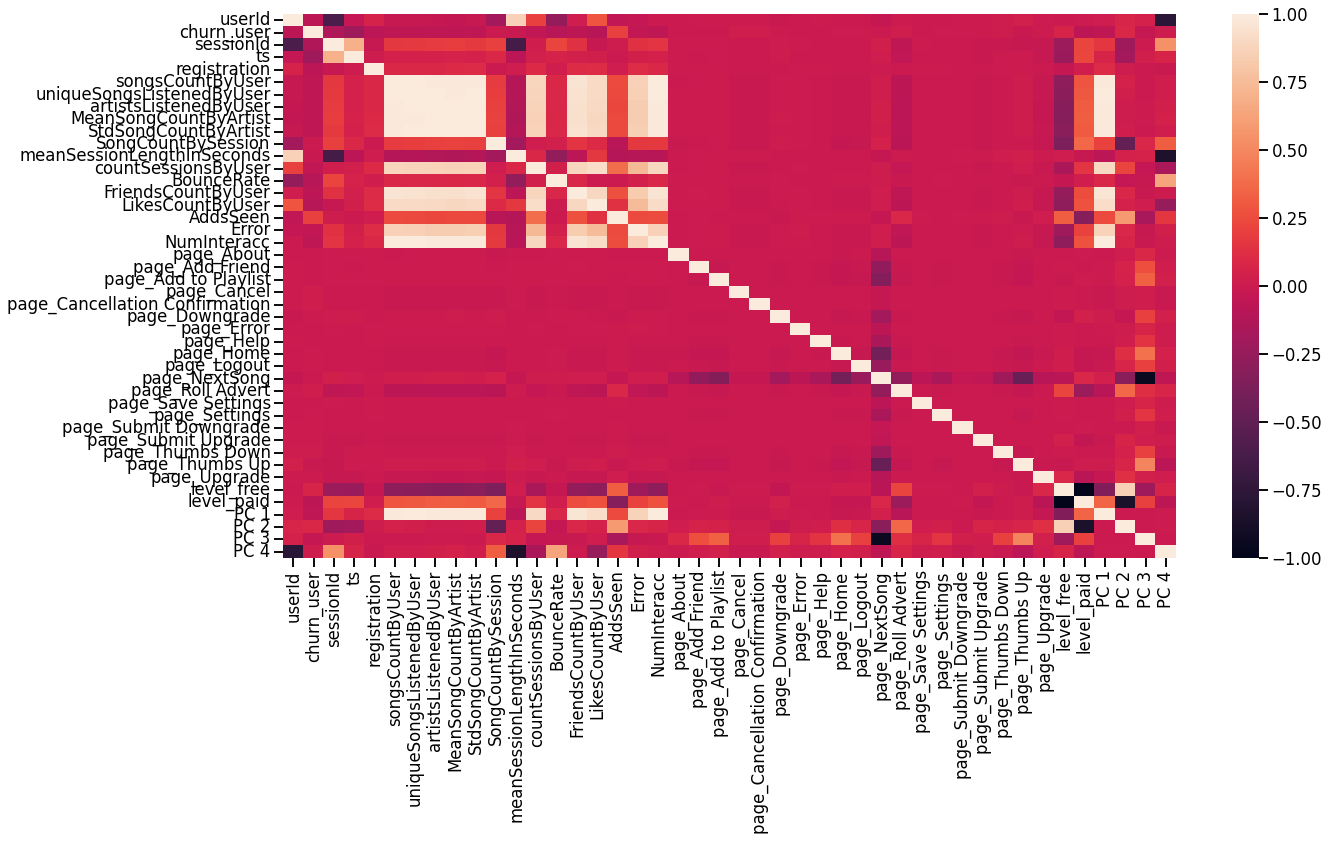

In [ ]:
plt.figure(figsize=(20,10))
sns.heatmap(corr_all_cols, 
        xticklabels=corr_all_cols.columns,
        yticklabels=corr_all_cols.columns)
plt.show()

En el grafico podemos ver las intensidades de la correlaciones de las variables, se observa que las variabes `uniqueSongsListenedByUser`, `artistsListenedByUser`, `MeanSongCountByArtist`, `StdSongCountByArtist`, `FriendsCountByUser`, `countSessionsByUser`,`FriendsCountByUser`,`LikesCountByUser`, `NumInteracc` se encuentran con una correlación superior a **0.75** *entre las mismas* y con la variable **PC1** lo cual tiene sentido al ser la Componente Principal.

##3.b - Eliminar Features

Eliminar los features fuertemente correlacionadas (una de cada par), ya que mantener columnas altamente correlacionadas, puede ocasionar un comportamiento no deseado en los modelos de clasificación



Para eliminar features tomaremos como umbral aquellas que en la matriz de correlaciones entre features (ejercicio 3.a) superen a **0.90** en relación a `songsCountByUser`. 

Las variables por encima de este valor son:  `uniqueSongsListenedByUser`(0.99), `artistsListenedByUser`(0.98), `MeanSongCountByArtist`(0.98), `StdSongCountByArtist`(0.98),`FriendsCountByUser`(0.95),`LikesCountByUser`(0.91).



In [ ]:
excluded_cols = ['uniqueSongsListenedByUser', 'artistsListenedByUser', 'MeanSongCountByArtist', 'StdSongCountByArtist','FriendsCountByUser','LikesCountByUser']

In [ ]:
interesting_cols = [col for col in expanded_df.columns.to_list() if col not in excluded_cols]

In [ ]:
new_df = expanded_df.copy()

In [ ]:
df_final = new_df[interesting_cols]
df_final

,userId,churn_user,sessionId,ts,registration,songsCountByUser,SongCountBySession,meanSessionLengthInSeconds,countSessionsByUser,BounceRate,AddsSeen,Error,NumInteracc,page_About,page_Add Friend,page_Add to Playlist,page_Cancel,page_Cancellation Confirmation,page_Downgrade,page_Error,page_Help,page_Home,page_Logout,page_NextSong,page_Roll Advert,page_Save Settings,page_Settings,page_Submit Downgrade,page_Submit Upgrade,page_Thumbs Down,page_Thumbs Up,page_Upgrade,level_free,level_paid,PC 1,PC 2,PC 3,PC 4
0,293.0,1.0,292.0,1.538352e+09,1.532064e+12,1.103343,-0.917593,-0.309990,1.532090,-0.457105,0.966526,0.474252,1.110359,-0.044083,-0.124722,-0.154758,-0.013695,-0.013695,-0.085167,-0.030881,-0.070917,-0.193638,-0.107124,0.468687,-0.122152,-0.033305,-0.075074,-0.014888,-0.023321,-0.096897,-0.217395,-0.042814,1.949918,-1.949918,2.921311,3.118063,-1.445327,-0.175674
1,98.0,0.0,97.0,1.538352e+09,1.538070e+12,0.214459,-1.204079,-0.837903,0.076538,0.329148,-0.648117,1.610501,0.196979,-0.044083,-0.124722,-0.154758,-0.013695,-0.013695,-0.085167,-0.030881,-0.070917,-0.193638,-0.107124,0.468687,-0.122152,-0.033305,-0.075074,-0.014888,-0.023321,-0.096897,-0.217395,-0.042814,1.949918,-1.949918,0.444724,2.190267,-1.259645,0.623612
2,179.0,0.0,178.0,1.538352e+09,1.535953e+12,-0.052378,-0.407510,-0.839457,-0.375185,-0.457105,-0.758206,-1.040746,-0.072894,-0.044083,-0.124722,-0.154758,-0.013695,-0.013695,-0.085167,-0.030881,-0.070917,-0.193638,-0.107124,0.468687,-0.122152,-0.033305,-0.075074,-0.014888,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,-0.330131,-1.035579,-0.392071,0.140678
3,179.0,0.0,178.0,1.538352e+09,1.535953e+12,-0.052378,-0.407510,-0.839457,-0.375185,-0.457105,-0.758206,-1.040746,-0.072894,-0.044083,-0.124722,-0.154758,-0.013695,-0.013695,-0.085167,-0.030881,-0.070917,-0.193638,9.334947,-2.133620,-0.122152,-0.033305,-0.075074,-0.014888,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,-0.402951,-0.039177,2.906688,0.585036
4,246.0,1.0,245.0,1.538352e+09,1.535931e+12,0.392350,-0.239812,0.257587,-0.224611,-0.457105,-0.060974,0.853002,0.368327,-0.044083,-0.124722,-0.154758,-0.013695,-0.013695,-0.085167,-0.030881,-0.070917,-0.193638,-0.107124,0.468687,-0.122152,-0.033305,-0.075074,-0.014888,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,1.127700,-0.600384,-0.445906,-0.528947
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
527961,300010.0,0.0,882.0,1.543622e+09,1.536850e+12,-0.734863,-0.281736,1.865848,-0.877100,-0.457105,-0.538027,-0.661996,-0.724492,-0.044083,-0.124722,-0.154758,-0.013695,-0.013695,-0.085167,-0.030881,-0.070917,-0.193638,-0.107124,0.468687,-0.122152,-0.033305,-0.075074,-0.014888,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,-2.199657,-1.093086,-0.269333,-1.783236
527962,300049.0,0.0,991.0,1.543622e+09,1.537523e+12,2.034420,-0.407510,1.948744,3.238600,-0.457105,0.599561,1.989250,2.149871,-0.044083,-0.124722,-0.154758,-0.013695,-0.013695,-0.085167,-0.030881,-0.070917,-0.193638,-0.107124,0.468687,-0.122152,-0.033305,-0.075074,-0.014888,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,7.206508,0.803313,-0.567823,-2.581461
527963,300039.0,0.0,916.0,1.543622e+09,1.536229e+12,-1.236607,-1.043367,3.275243,-1.178249,-0.457105,-0.648117,-1.040746,-1.240440,-0.044083,-0.124722,-0.154758,-0.013695,-0.013695,-0.085167,-0.030881,-0.070917,-0.193638,-0.107124,0.468687,-0.122152,-0.033305,-0.075074,-0.014888,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,-4.122541,-1.044259,-0.224348,-2.964251
527964,300038.0,0.0,966.0,1.543622e+09,1.535616e+12,-0.024440,-1.015418,1.719792,0.578452,-0.457105,0.195901,0.095503,0.017540,-0.044083,-0.124722,-0.154758,-0.013695,-0.013695,-0.085167,-0.030881,-0.070917,-0.193638,-0.107124,0.468687,-0.122152,-0.033305,-0.075074,-0.014888,-0.023321,-0.096897,-0.217395,-0.042814,-0.512842,0.512842,0.522951,-0.169011,-0.460053,-2.0453

#4 - Generar dataset “limpio”

Guardar en un nuevo csv el dataset “limpio”, con las transformaciones y nuevas columnas, ya que será el que utilizaremos en los siguientes TP para un modelo de clasificación.

In [ ]:
#Guardamos un archivo con nuestro nuevo Df sin las columnas fuertemente correlacionadas
df_final.to_csv('df_churn_clean.csv',index=False)

In [ ]:
from google.colab import files
files.download('df_churn_clean.csv') 